In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 4.7 MB 30.0 MB/s 
     |████████████████████████████████| 6.6 MB 60.9 MB/s 
     |████████████████████████████████| 101 kB 14.5 MB/s 
     |████████████████████████████████| 596 kB 68.8 MB/s 


In [ ]:
'''Import libraries'''

# Basic
from random import randint
import numpy as np
import pandas as pd
from collections import defaultdict
from textwrap import wrap
import os

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep learning
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Graphic
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

#Google disc
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
from google.colab import files



# Presets
sns.set(style='darkgrid', palette='bright', font_scale=1.2)
rcParams['figure.figsize'] = 10, 5
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
PRE_TRAINED_MODEL_NAME = 'DeepPavlov/rubert-base-cased-sentence'

# Check GPU 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.12.0+cu113
transformers: 4.21.0



## Defining functions and classes

In [ ]:
'''This function will download files from google disk by id'''
def gdisk_download(id,file_name):
  
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(f'{file_name}') 


In [ ]:
'''Class with nlp model'''

class TransformerModel(nn.Module):

    def __init__(self, n_classes):
        super(TransformerModel, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,
                                              return_dict=False)
        self.drop = nn.Dropout(p=0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids,
                                     attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
'''This class will prepare our data to feed the model'''

class RatingDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True )

        return {'review_text': review,'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)}

In [ ]:
'''It's global class to work with text rating prediction 
from preparing raw data for the model to evaluating the results'''

class RatingClassifier():
    
    def __init__(self,class_names = ['negative', 'neutral', 'positive']):
        self.class_names = class_names # User may change class quantity and names
        self.tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
    
    # This will create data loaders to feed the model
    def create_data_loader(self,df, tokenizer, max_len, batch_size):
    
        ds = RatingDataset(reviews=df.text.to_numpy(),
                           targets=df.rating.to_numpy(),
                           tokenizer=tokenizer,
                           max_len=max_len)
        
        return DataLoader(ds,batch_size=batch_size,num_workers=2)  
        
    # Train model foe one epoch
    def train_epoch(self,model,data_loader,loss_fn,optimizer, 
                device,scheduler,n_examples):
        model = model.train()
        losses = []
        correct_predictions = 0

        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        return correct_predictions.double() / n_examples, np.mean(losses)
    
    # Evaluating epoch results
    def eval_model(self,model, data_loader, loss_fn, device, n_examples):
        model = model.eval()

        losses = []
        correct_predictions = 0

        with torch.no_grad():
            for d in data_loader:
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                targets = d["targets"].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                _, preds = torch.max(outputs, dim=1)

                loss = loss_fn(outputs, targets)

                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())

        return correct_predictions.double() / n_examples, np.mean(losses)
    
    # Fit the model
    def fit(self,dataset, train_size = 0.8, # Here we can change train size 
            model_name ='Untitled'): # and model name to save the results
    
        # Splitting data
        df_train, df_test = train_test_split(dataset,
                                         train_size=train_size,
                                         stratify = dataset.rating,
                                         random_state=RANDOM_SEED)
        df_val, df_test = train_test_split(df_test, test_size=0.5,
                                           stratify = df_test.rating,
                                           random_state=RANDOM_SEED)
        
        # Checking shapes:
        print(f' Train shape: {df_train.shape}\n',
          f'Validation shape: {df_val.shape}\n',
          f'Test shape: {df_test.shape}')

        # Make loaders
        train_data_loader = self.create_data_loader(df_train, self.tokenizer, 
                                               MAX_LEN, BATCH_SIZE)
        val_data_loader = self.create_data_loader(df_val, self.tokenizer, 
                                             MAX_LEN, BATCH_SIZE)
        self.test_data_loader = self.create_data_loader(df_test, self.tokenizer, 
                                              MAX_LEN, BATCH_SIZE)

        # Forward data to device 
        data = next(iter(train_data_loader))
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        
        self.model = TransformerModel(len(self.class_names))
        self.model = self.model.to(device)
        # Add softmax layer to split results by categories:
        F.softmax(self.model(input_ids, attention_mask), dim=1)
        # This parameters are adviced by developers:    
        optimizer = AdamW(self.model.parameters(), lr=2e-5, correct_bias=False)
        loss_fn = nn.CrossEntropyLoss().to(device)
        total_steps = len(train_data_loader) * EPOCHS
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
            )

        self.history = defaultdict(list)# here metrics will be saved
        best_accuracy = 0# This is to choose the best model
        # Trainging... 
        for epoch in range(EPOCHS):

            print(f'Epoch {epoch + 1}/{EPOCHS}')
            print('-' * 10)

            train_acc, train_loss = self.train_epoch(
                self.model, train_data_loader,    
                loss_fn,optimizer, 
                device, scheduler,len(df_train))

            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = self.eval_model(
                self.model, val_data_loader,
                loss_fn, device, len(df_val))

            print(f'Val   loss {val_loss} accuracy {val_acc}')
            print()
            # Saving metrics
            self.history['train_acc'].append(train_acc.item())
            self.history['train_loss'].append(train_loss)
            self.history['val_acc'].append(val_acc.item())
            self.history['val_loss'].append(val_loss)

            if val_acc > best_accuracy:# Save best model
                torch.save(self.model.state_dict(),
                           f'{path}{model_name}.bin')
                best_accuracy = val_acc
           
        self.show_report()# Show classification report 
    
    def plot_history(self):# Visualize training process
        try:
            plt.plot(self.history['train_acc'],color = 'b', label='train accuracy')
            plt.plot(self.history['val_acc'], color = 'g', label='validation accuracy')
            plt.title('Training history')
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')
            plt.legend()
            plt.ylim([0.5, 1])
        
        except AttributeError:# operate the error if model hasn't been trained:
            print("Fit model at first!") 
    
    def show_report(self):# Use sklearn library to show metrics
        try:
            model = self.model.eval()

            self.review_texts = []
            predictions = []
            prediction_probs = []
            real_values = []

            with torch.no_grad():
                for d in self.test_data_loader:

                    texts = d["review_text"]
                    input_ids = d["input_ids"].to(device)
                    attention_mask = d["attention_mask"].to(device)
                    targets = d["targets"].to(device)

                    outputs = model(input_ids=input_ids,
                                    attention_mask=attention_mask)
                    _, preds = torch.max(outputs, dim=1)

                    probs = F.softmax(outputs, dim=1)

                    self.review_texts.extend(texts)
                    predictions.extend(preds)
                    prediction_probs.extend(probs)
                    real_values.extend(targets)

            self.predictions = torch.stack(predictions).cpu()
            self.prediction_probs = torch.stack(prediction_probs).cpu()
            self.real_values = torch.stack(real_values).cpu()

            print('Classification Report\n')
            print(classification_report(self.real_values, self.predictions,
                                        target_names=self.class_names))
        except AttributeError:
            print("Fit model at first!")
    
    # The most descriptive visualization for classifying models
    def show_confusion_matrix(self):
        try:    
            cm = confusion_matrix(self.real_values, self.predictions)
            df_cm = pd.DataFrame(cm, index=self.class_names, columns=self.class_names)

            hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
            hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
            hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
            plt.ylabel('True rating')
            plt.xlabel('Predicted rating')
    
        except AttributeError:
            print("Fit model at first!")
    
    # This method shows us text from dataset and it's class probability
    def show_probability(self,index):
        try:
        
            pred_df = pd.DataFrame({'class_names': self.class_names,
                                    'values': self.prediction_probs[index]})

            print("\n".join(wrap(self.review_texts[index])))
            print()
            print(f'True rating: {self.class_names[self.real_values[index]]}')
            sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
            plt.ylabel('rating')
            plt.xlabel('probability')
            plt.xlim([0, 1])
        
        except AttributeError:
            print("Fit model at first!")
    
    # Predicing the class of random text: 
    def predict(self,text):
        try:
            encoded_review = self.tokenizer.encode_plus(
              text,
              max_length=MAX_LEN,
              add_special_tokens=True,
              return_token_type_ids=False,
              pad_to_max_length=True,
              return_attention_mask=True,
              return_tensors='pt',
              padding='max_length',
              truncation=True     
            )

            input_ids = encoded_review['input_ids'].to(device)
            attention_mask = encoded_review['attention_mask'].to(device)

            output = self.model(input_ids, attention_mask)
            _, prediction = torch.max(output, dim=1)
        
        except AttributeError:
            print("Fit model at first!")
        
        return int(prediction) 
    
    # load early saved model parameters
    def load_model(self,file_name):
           
        self.model = TransformerModel(len(self.class_names))
        self.model.load_state_dict(torch.load(file_name))
        self.model = self.model.to(device)
    
    # This visualisation will help us in choosing the length to cut the sentense
    def show_sentenses_lengths(self,series,max_length = 500):

        token_lenghts = []

        for txt in series:
            tokens = self.tokenizer.encode(txt, max_length=max_length,
                                           truncation=True)
            token_lenghts.append(len(tokens))

        sns.displot(token_lenghts)
        plt.xlim([0, max_length + 100])
        plt.xlabel('Sentense length')   


We'll set class marks:  
0 - negative  
1 - neutral  
2 - positive

#### Sentiment analysis in Russian dataset from kaggle (SAR)

In [ ]:
'''Downloading dataset'''
gdisk_download('1PFxJA3JYbOPAxn1ysTheiy-Au5zDs0AH',
               'SAR.csv')
sar = pd.read_csv('SAR.csv')
sar.head(10)
print(sar.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8263 entries, 0 to 8262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8263 non-null   object
 1   rating  8263 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 129.2+ KB
None


In [ ]:
sar.rating.value_counts()

1    4034
2    2795
0    1434
Name: rating, dtype: int64

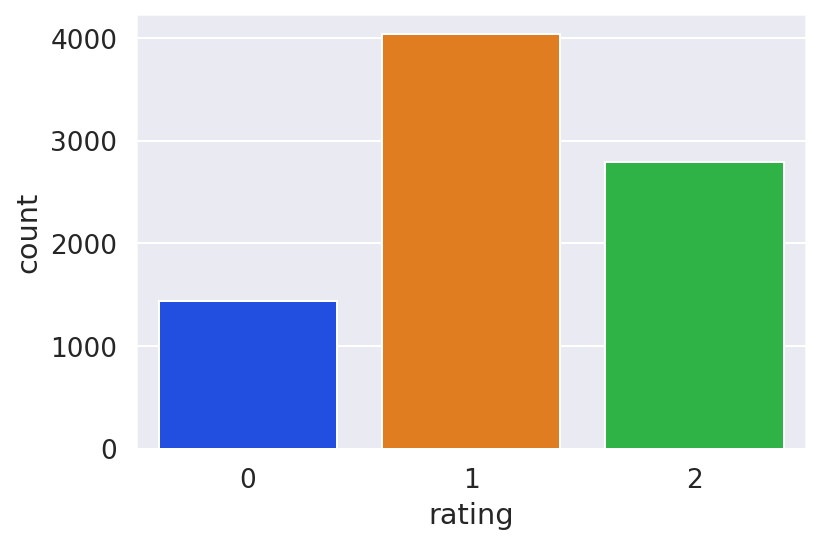

In [ ]:
'''From the graphic  we can see that the class distribution
is strongly uneven'''

sns.countplot(x = sar.rating)

#### Russian tweets sentiment dataset from kaggle(RTS)

In [ ]:
'''Downloading dataset'''
gdisk_download('1P2NvaG8G6JI6rEIpEIOFEqdl4wc30yg9',
               'RTS.csv')
rts = pd.read_csv('RTS.csv')
rts.head(10)

,text,rating
0,"Коллеги сидят рубятся в Urban terror, а я из-з...",0
1,@elina_4post как говорят обещаного три года жд...,0
2,"Желаю хорошего полёта и удачной посадки,я буду...",0
3,"Обновил за каким-то лешим surf, теперь не рабо...",0
4,"Котёнка вчера носик разбила, плакала и расстра...",0
5,"@juliamayko @O_nika55 @and_Possum Зашли, а то ...",0
6,а вообще я не болею - я не выздоравливаю :(,0
7,я микрофраза :( учимся срать кирпичами в режим...,0
8,"я хочу с тобой помириться , но сука я гордая и...",0
9,@DNO_OKEANA_A3A3 @MOE_MOPE_A3A3 тебя ебет каки...,0


In [ ]:
"""Combine datasets and equalize classes"""
sar_rts = sar
sar_rts = sar_rts.append(rts[rts['rating'] == 0][0:2500])
sar_rts = sar_rts.append(rts[rts['rating'] == 2][0:1300])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12063 entries, 0 to 113221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12063 non-null  object
 1   rating  12063 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 540.8+ KB
None


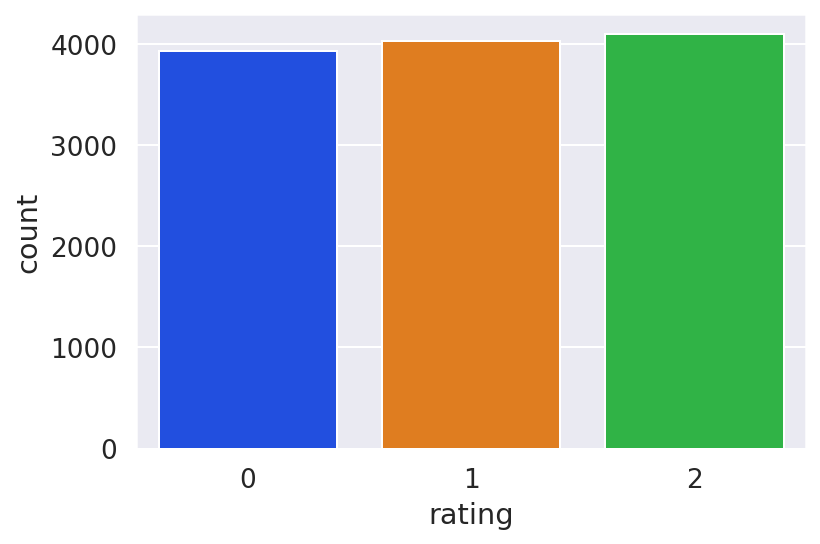

In [ ]:
'''Now we have normal class distribution'''
sns.countplot(x = sar_rts.rating)
print(sar_rts.info())

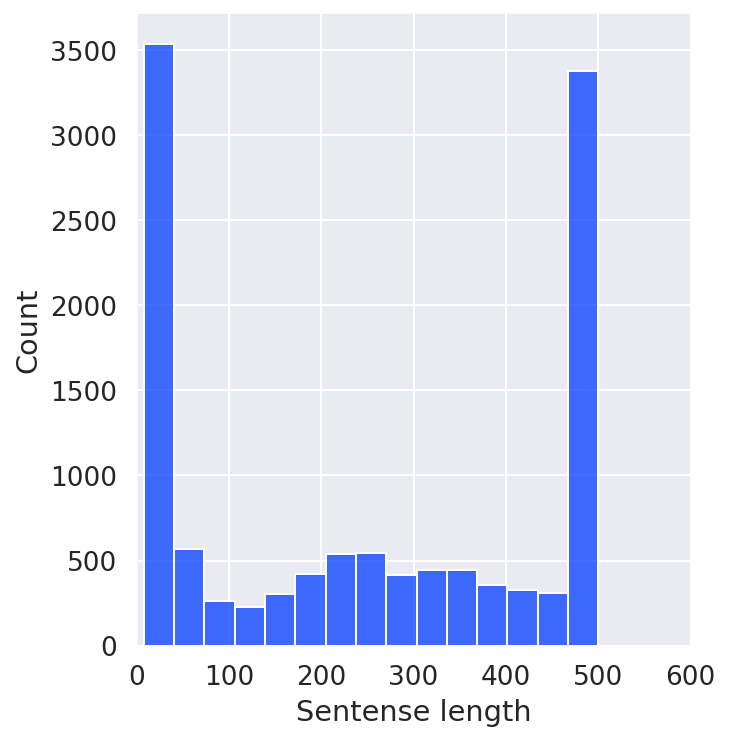

In [ ]:
'''Create classifier and draw graphc to choose the maximum 
lenght of the sentenses in our texts:'''
sar_rts_model = RatingClassifier()
sar_rts_model.show_sentenses_lengths(sar_rts.text) 

In [ ]:
!nvidia-smi

Sun Jul 31 08:05:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "drive/MyDrive/!Projects/HackItVol/"

Mounted at /content/drive


In [ ]:
%%time
'''Training the model'''
MAX_LEN = 500
BATCH_SIZE = 12
EPOCHS = 2
sar_rts_model.fit(sar_rts[['text','rating']],model_name = 'sar_rts_model')

 Train shape: (9650, 2)
 Validation shape: (1206, 2)
 Test shape: (1207, 2)


Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Train loss 0.5919049975294504 accuracy 0.7208290155440414
Val   loss 0.48666832441150554 accuracy 0.7786069651741294

Epoch 2/2
----------
Train loss 0.3967121882884769 accuracy 0.8310880829015544
Val   loss 0.5272140151055733 accuracy 0.7769485903814263

Classification Report

              precision    recall  f1-score   support

    negative       0.87      0.88      0.87       393
     neutral       0.69      0.70      0.69       404
    positive       0.81      0.79      0.80       410

    accuracy                           0.79      1207
   macro avg       0.79      0.79      0.79      1207
weighted avg       0.79      0.79      0.79      1207

CPU times: user 32min 55s, sys: 37.5 s, total: 33min 33s
Wall time: 34min 1s


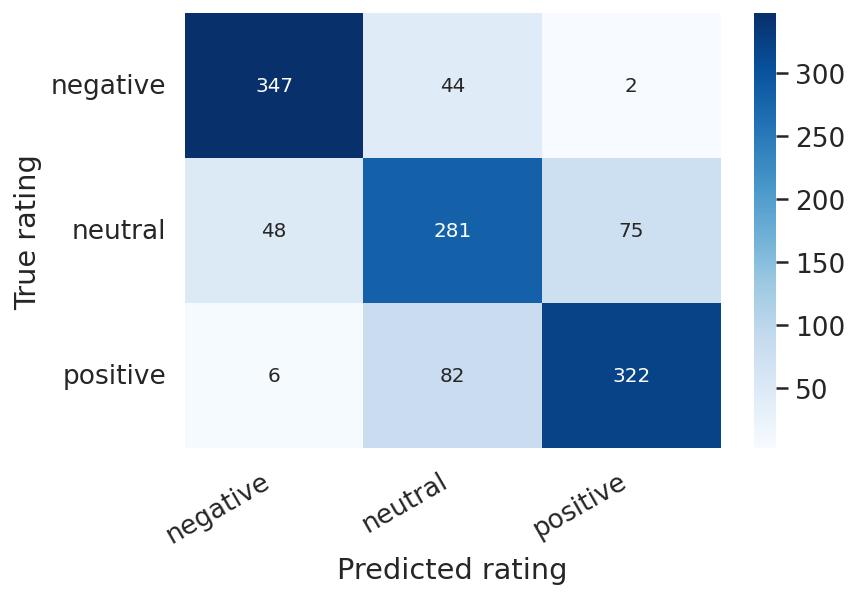

In [ ]:
sar_rts_model.show_confusion_matrix()

 12:48 19.10.2016 Автостат   В рубрике: Транспортные новости:
Автотранспорт Машиностроение Автопром Казахстана в сентябре показал
рост на 46% Свыше 80% от этого объема приходится на легковые
автомобили, которых было выпущено в количестве 853 штук, что на 68,2%
превосходит аналогичный показатель 2015 года. Соответственно
оставшиеся 166 экземпляров включают грузовой транспорт и автобусную
технику.   Транспортные проекты: Мировые автоновости  Регион:
Казахстан    Москва. 19 октября. Logistic.Ru — В сентябре 2016 года в
Казахстане в общей сложности было произведено 1019 единиц
автомобильной техники. Это на 46% выше прошлогоднего результата,
сообщает пресс-служба Союза предприятий автомобильной отрасли
Казахстана «КазАвтоПром». Свыше 80% от этого объема приходится на
легковые автомобили, которых было выпущено в количестве 853 штук, что
на 68,2% превосходит аналогичный показатель 2015 года. Соответственно
оставшиеся 166 экземпляров включают грузовой транспорт и автобусную
технику. Всего же з

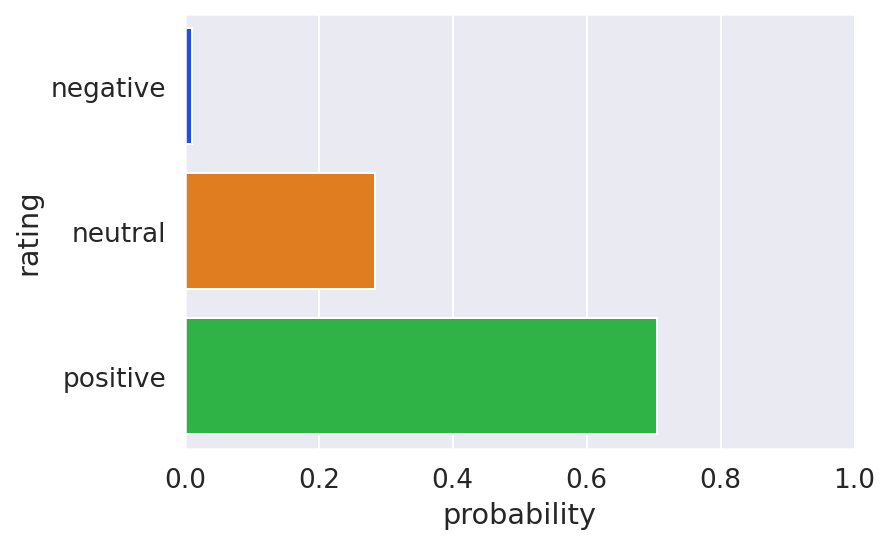

In [ ]:
'''You can run the cell several times to see the random text
and it's prediction probability''' 
random_index = randint(0,len(sar_rts_model.review_texts))
sar_rts_model.show_probability(random_index)